In [48]:
import cv2
import numpy as np
import json
import os
import matplotlib.pyplot as plt

def annotate_points_on_capture(capture_dir, points_2d, scale=0.0001):
    """
    Load OAK-D capture (RGB, depth, metadata), compute 3D coords for given points,
    annotate them on the RGB image and display with matplotlib.

    Parameters:
        capture_dir (str): path to capture_* directory
        points_2d (list of (u,v)): list of pixel coordinates in RGB image
        scale (float): depth unit scale (0.001 if depth in mm, 1.0 if already in m)
    """

    # ---- Load files ----
    rgb_path = os.path.join(capture_dir, "rgb_4k.jpg")
    depth_npy_path = os.path.join(capture_dir, "depth.npy")
    metadata_path = os.path.join(capture_dir, "metadata.json")

    rgb = cv2.imread(rgb_path)
    if rgb is None:
        raise FileNotFoundError(f"Could not load RGB image: {rgb_path}")
    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)

    depth = np.load(depth_npy_path)
    
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)

    # ---- Intrinsics ----
    K = np.array(metadata["intrinsics_matrix"])
    fx, fy, cx, cy = K[0,0], K[1,1], K[0,2], K[1,2]

    # ---- Resize depth if needed ----
    if depth.shape[:2] != rgb.shape[:2]:
        depth_resized = cv2.resize(depth, (rgb.shape[1], rgb.shape[0]), interpolation=cv2.INTER_NEAREST)
    else:
        depth_resized = depth
    print(depth_resized[depth_resized>0])
    cv2.imwrite("a.png",depth_resized.astype(np.uint8))
    # ---- Back-projection ----
    def deproject(u, v, depth_value):
        print(depth_value, cx, cy, fx, fy, 882.5*0.75/depth_value)
        Z = depth_value * scale
        if Z <= 0:
            return None
        X = (u - cx) * Z / fx
        Y = (v - cy) * Z / fy
        return np.array([X, Y, Z])

    # ---- Annotate points ----
    results = []
    for (u, v) in points_2d:
        if not (0 <= u < rgb.shape[1] and 0 <= v < rgb.shape[0]):
            print(f"Point ({u},{v}) is outside the image bounds, skipping.")
            continue

        d = depth_resized[v, u]
        xyz = deproject(u, v, d)

        if xyz is not None:
            dist = np.linalg.norm(xyz)
            results.append(((u, v), xyz, dist))

            cv2.circle(rgb, (u, v), 10, (255, 0, 0), -1)
            cv2.putText(rgb, f"d={dist:.2f}m", (u+20, v),
                        cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 5)
            cv2.putText(rgb, f"vec={xyz.round(2)}", (u+20, v+80),
                        cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 5)

            print(f"({u},{v}) depth={d} -> XYZ={xyz}, dist={dist:.2f}m")
        else:
            print(f"({u},{v}) invalid depth (0)")

    # ---- Show result ----
    plt.figure(figsize=(14,10))
    plt.imshow(rgb)
    plt.axis("off")
    plt.title("OAK-D 4K with 3D measurements")
    plt.show()

    return results, rgb

[7748 7748 7748 ... 1854 1854 1854]
2470 1920.0 1080.0 3142.0 3146.0 0.26796558704453444
(1725,972) depth=2470 -> XYZ=[-0.01532941 -0.00847934  0.247     ], dist=0.25m


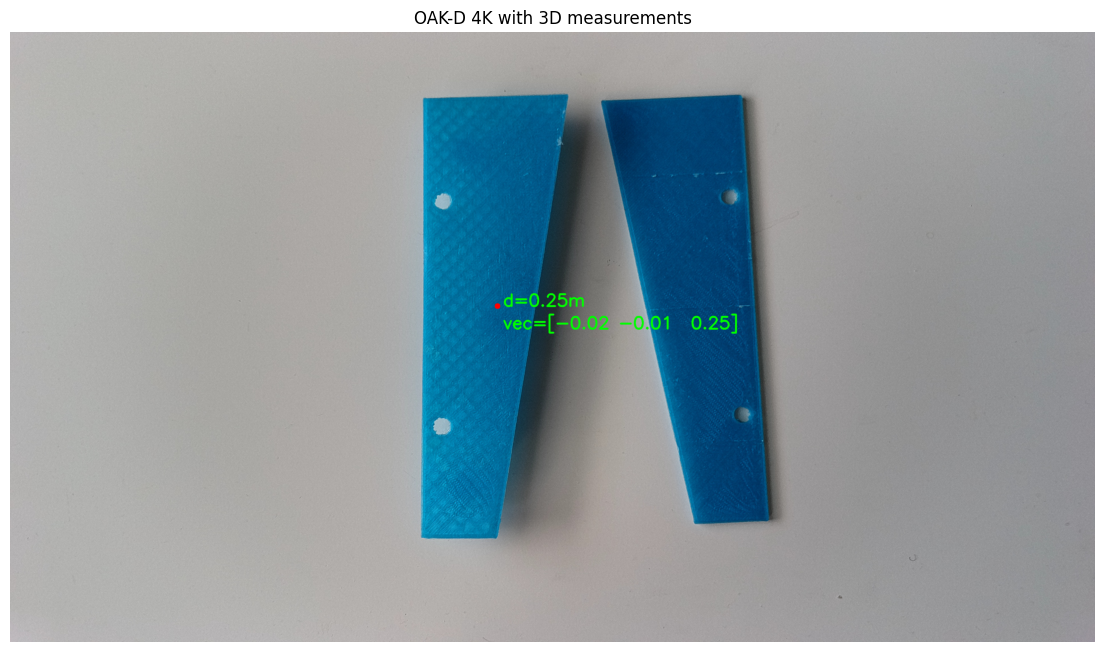

Pixel (1725, 972): XYZ=[-0.01532941 -0.00847934  0.247     ], Distance=0.25m


In [49]:
capture_dir = "oakd_captured_depths/capture_20250901_133857_004"
points = [(1725,972)]

results, annotated = annotate_points_on_capture(capture_dir, points)

# results съдържа [( (u,v), xyz, distance ), ...]
for (uv, xyz, dist) in results:
    print(f"Pixel {uv}: XYZ={xyz}, Distance={dist:.2f}m")

[664 664 664 ... 716 716 716]
3594 1920.0 1080.0 3142.0 3146.0 0.184161101836394
(1611,1185) depth=3594 -> XYZ=[-0.03534519  0.01199523  0.3594    ], dist=0.36m


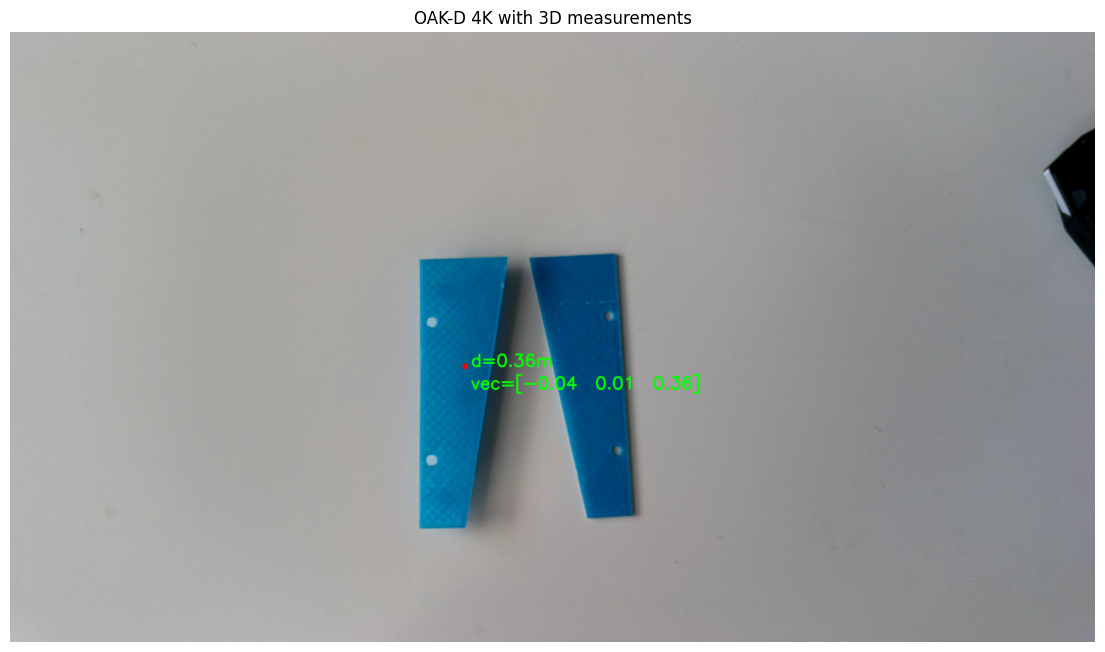

Pixel (1611, 1185): XYZ=[-0.03534519  0.01199523  0.3594    ], Distance=0.36m


In [50]:
capture_dir = "oakd_captured_depths/capture_20250901_133909_005"
points = [(1611,1185)]

results, annotated = annotate_points_on_capture(capture_dir, points)

# results съдържа [( (u,v), xyz, distance ), ...]
for (uv, xyz, dist) in results:
    print(f"Pixel {uv}: XYZ={xyz}, Distance={dist:.2f}m")